In [1]:
# Import libs
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import re as re
from pandas.io.json import json_normalize
import json # library to handle JSON files
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
import geocoder
import geopandas as gpd
import fiona
import json

# Prepare neighborhood list: Manhattan

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_Manhattan_neighborhoods'
results = requests.get(url)
soup = BeautifulSoup(results.content)

In [3]:
MA_info = soup.find_all('table', attrs = {'class':'wikitable sortable'})

In [4]:
MA_list = []
for area in MA_info:
    list_data = area.tbody.find_all('tr')
    for row in list_data[1:]:
        MA_list.append(row.find('td').text.replace('\n', '').strip())
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = re.split('[(,\[†]', neighborhood)[0].strip()
        except:
            pass
    for index, neighborhood in enumerate(MA_list):
        try:
            MA_list[index] = neighborhood.split(' aka ')[0].strip()
        except:
            pass
MA_list[-3] = MA_list[-3].replace('Historical District','').strip()
MA_list[62] = MA_list[62].replace('and Loisaida', '').strip()
MA_list

['Upper Manhattan',
 'Marble Hill',
 'Inwood',
 'Fort George',
 'Washington Heights',
 'Hudson Heights',
 'West Harlem',
 'Hamilton Heights',
 'Manhattanville',
 'Morningside Heights',
 'Central Harlem',
 'Harlem',
 'St. Nicholas Historic District',
 'Astor Row',
 'Sugar Hill',
 'Marcus Garvey Park',
 'Le Petit Senegal',
 'East Harlem',
 'Upper East Side',
 'Lenox Hill',
 'Carnegie Hill',
 'Yorkville',
 'Upper West Side',
 'Manhattan Valley',
 'Lincoln Square',
 'Columbus Circle',
 'Sutton Place',
 'Rockefeller Center',
 'Diamond District',
 'Theater District',
 'Turtle Bay',
 'Midtown East',
 'Midtown',
 'Tudor City',
 'Little Brazil',
 'Times Square',
 'Hudson Yards',
 'Midtown West',
 "Hell's Kitchen",
 'Garment District',
 'Herald Square',
 'Koreatown',
 'Murray Hill',
 'Tenderloin',
 'Madison Square',
 'Flower District',
 'Brookdale',
 'Hudson Yards',
 'Kips Bay',
 'Rose Hill',
 'NoMad',
 'Peter Cooper Village',
 'Chelsea',
 'Flatiron District',
 'Gramercy Park',
 'Stuyvesant Squa

# Prepare neighborhood list: DC

In [5]:
url = 'https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/35/query?where=1%3D1&outFields=NAME&outSR=4326&f=json'
results = requests.get(url).json()
DC_list_full = json_normalize(results['features'])
DC_list_full.columns = ['Name', 'Latitude', 'Longitude']

<ipython-input-5-036be7523f7b>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  DC_list_full = json_normalize(results['features'])


In [6]:
DC_list_full['Name'] = DC_list_full['Name'].str.replace('-',' ', regex=False)

def name_correct(name, delimit='/'):
    return name.split(delimit)[0]

DC_list_full['Name'] = DC_list_full['Name'].apply(name_correct)
DC_list = DC_list_full['Name'].tolist()
DC_list

['Fort Stanton',
 'Congress Heights',
 'Washington Highlands',
 'Bellevue',
 'Knox Hill',
 'Shipley',
 'Douglass',
 'Woodland',
 'Garfield Heights',
 'Near Southeast',
 'Capitol Hill',
 'Dupont Park',
 'Twining',
 'Randle Highlands',
 'Fairlawn',
 'Penn Branch',
 'Barry Farm',
 'Historic Anacostia',
 'Columbia Heights',
 'Logan Circle',
 'Cardozo',
 'Van Ness',
 'Forest Hills',
 'Georgetown Reservoir',
 'Foxhall Village',
 'Fort Totten',
 'Pleasant Hill',
 'Kenilworth',
 'Eastland Gardens',
 'Deanwood',
 'Fort Dupont',
 'Greenway',
 'Woodland Normanstone',
 'Mass. Ave. Heights',
 'Naylor Gardens',
 'Pleasant Plains',
 'Hillsdale',
 'Benning Ridge',
 'Penn Quarter',
 'Chinatown',
 'Stronghold',
 'South Central',
 'Langston',
 'Downtown East',
 'North Portal Estates',
 'Colonial Village',
 'Shepherd Park',
 'Takoma',
 'Lamond Riggs',
 'Petworth',
 'Brightwood Park',
 'Manor Park',
 'Brightwood',
 'Hawthorne',
 'Barnaby Woods',
 'Queens Chapel',
 'Michigan Park',
 'North Michigan Park',
 

## Function to generate points in polygon

In [7]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import random

def random_points_in_polygon(number, polygon, seed=10):
    random.seed(seed)
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

# Prepare neighborhood list: Beijing

In [8]:
# Density of neighborhood in DC
neighborhood_dens_DC = len(DC_list) / 68.34
neighborhood_dens_MA = len(MA_list) / 22.82
print('DC: {} per sq mi'.format(neighborhood_dens_DC))
print('MA: {} per sq mi'.format(neighborhood_dens_MA))

DC: 1.9315188762071993 per sq mi
MA: 3.6809815950920246 per sq mi


In [9]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
BJ_downtown = gpd.read_file('Beijing.kml', driver='KML')

In [10]:
num_BJ = int(neighborhood_dens_DC * 60.8)
points = random_points_in_polygon(num_BJ, BJ_downtown.iloc[0].geometry, seed=3)

# Coordinates of the first point
BJ_x = [point.x for point in points]
BJ_y = [point.y for point in points]

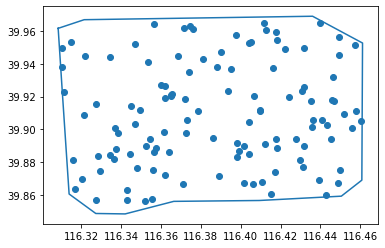

In [11]:
plt.plot(*BJ_downtown.iloc[0,2].exterior.xy)
plt.scatter(BJ_x, BJ_y)

# Prepare neighborhood list: Shanghai

In [12]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
SH_downtown = gpd.read_file('Shanghai.kml', driver='KML')

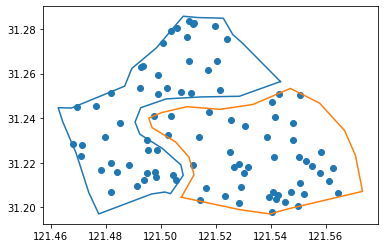

In [13]:
num_SH = int(neighborhood_dens_MA * 24.1/2)
seed0 = 9
points1 = random_points_in_polygon(num_SH, SH_downtown.iloc[0].geometry, seed=seed0)
points2 = random_points_in_polygon(num_SH, SH_downtown.iloc[1].geometry, seed=seed0)

# Coordinates of the first point
SH_x = [point.x for point in points1] + [point.x for point in points2]
SH_y = [point.y for point in points1] + [point.y for point in points2]
plt.plot(*SH_downtown.iloc[0,2].exterior.xy)
plt.plot(*SH_downtown.iloc[1,2].exterior.xy)
plt.scatter(SH_x, SH_y)

# Request neighborhood position

## Mahattan

In [14]:
lat = []
lng = []
for neighborhood in MA_list:
    address = '{}, New York, NY'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

In [15]:
MA_table = pd.DataFrame(MA_list)
MA_table.columns = ['Neighborhoods']
MA_table

,Neighborhoods
0,Upper Manhattan
1,Marble Hill
2,Inwood
3,Fort George
4,Washington Heights
...,...
79,Civic Center
80,Radio Row
81,South Street Seaport
82,Battery Park City


In [16]:
MA_table['Latitude'] = lat
MA_table['Longitude'] = lng
MA_table

,Neighborhoods,Latitude,Longitude
0,Upper Manhattan,40.808810,-73.947770
1,Marble Hill,40.876410,-73.911000
2,Inwood,40.865950,-73.926070
3,Fort George,40.859187,-73.926459
4,Washington Heights,40.849830,-73.936030
...,...,...,...
79,Civic Center,40.713370,-74.003800
80,Radio Row,40.843567,-73.818163
81,South Street Seaport,40.705710,-74.001840
82,Battery Park City,40.711310,-74.015900


In [17]:
for row in range(MA_table.shape[0]):
    if (MA_table.loc[row, 'Latitude'] <= 40.65526141744085) or (MA_table.loc[row, 'Longitude'] >= -73.81816282365787):
        MA_table.drop(row, inplace=True)
MA_table.reset_index(drop=True, inplace=True)
MA_table

,Neighborhoods,Latitude,Longitude
0,Upper Manhattan,40.808810,-73.947770
1,Marble Hill,40.876410,-73.911000
2,Inwood,40.865950,-73.926070
3,Fort George,40.859187,-73.926459
4,Washington Heights,40.849830,-73.936030
...,...,...,...
73,Tribeca,40.718540,-74.008880
74,Civic Center,40.713370,-74.003800
75,South Street Seaport,40.705710,-74.001840
76,Battery Park City,40.711310,-74.015900


## Map of Mahattan

In [18]:
address = 'New York, NY'

g = geocoder.arcgis(address)
print(g.lat, g.lng)

40.71455000000003 -74.00713999999994


In [19]:
map_newyork = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(MA_table['Neighborhoods'], MA_table['Latitude'], MA_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_newyork)
map_newyork

## Request venues from Foursquare

### Define a required function

In [62]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    neighborhood_venues_info = []
    venues_info = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        neighborhood_venues_info.append(results)
        venues_info.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print(len(venues_info), ':', name)

    nearby_venues = pd.DataFrame([item for venue_info in venues_info for item in venue_info])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, venues_info, neighborhood_venues_info)

### Define Foursquare credential and version

In [63]:
CLIENT_ID = 'OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN' # your Foursquare ID
CLIENT_SECRET = '5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR' # your Foursquare Secret
ACCESS_TOKEN = 'VH53ZCZMIQSN033ZU2VDUZD1CRA5GJQE1SKGVRWNNF1FJINZ' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OQWZRAUBBN5XX5CTG4QJNUTGB1PLERCI32GLZWVRG4JJTOMN
CLIENT_SECRET:5J0EYVSGK2QSQXGA4TN5YPIIUY1NU0HDIRQNHRWWB4BXUUAR


In [217]:
names = MA_table['Neighborhoods'].tolist()
latitudes = MA_table['Latitude'].tolist()
longitudes = MA_table['Longitude'].tolist()
# MA_venues, MA_venues_info, MA_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

### Read already requested data

In [20]:
# Save requested data
MA_venues.to_csv('MA_venues.csv',index=False)
with open('MA_venues_info.txt','w') as fp:
    json.dump(MA_venues_info, fp)
with open('MA_neighborhood_venues_info.txt','w') as fp:
    json.dump(MA_neighborhood_venues_info, fp)

NameError: name 'MA_venues' is not defined

In [21]:
# Load saved data
MA_venues = pd.read_csv('MA_venues.csv')

with open('MA_venues_info.txt', 'r') as fp:
    MA_venues_info_backup = json.load(fp)
with open('MA_neighborhood_venues_info.txt', 'r') as fp:
    MA_neighborhood_venues_info_backup = json.load(fp)

___
## DC

In [22]:
lat = []
lng = []
for neighborhood in DC_list:
    address = '{}, Washington, DC'.format(neighborhood)
    g = geocoder.arcgis(address)
    lat.append(g.lat)
    lng.append(g.lng)

In [23]:
DC_table = pd.DataFrame(DC_list)
DC_table.columns = ['Neighborhoods']
DC_table

,Neighborhoods
0,Fort Stanton
1,Congress Heights
2,Washington Highlands
3,Bellevue
4,Knox Hill
...,...
127,Fort Davis Park
128,Fairfax Village
129,Hillcrest
130,Crestwood


In [24]:
DC_table['Latitude'] = lat
DC_table['Longitude'] = lng
DC_table

,Neighborhoods,Latitude,Longitude
0,Fort Stanton,38.85760,-76.97830
1,Congress Heights,38.84290,-77.00057
2,Washington Highlands,38.83198,-76.99700
3,Bellevue,38.82654,-77.00870
4,Knox Hill,38.85302,-76.97246
...,...,...,...
127,Fort Davis Park,38.86794,-76.94493
128,Fairfax Village,38.86372,-76.95220
129,Hillcrest,38.85941,-76.95566
130,Crestwood,38.94187,-77.03989


In [46]:
# for row in range(MA_table.shape[0]):
#     if (MA_table.loc[row, 'Latitude'] <= 40.65526141744085) or (MA_table.loc[row, 'Longitude'] >= -73.81816282365787):
#         MA_table.drop(row, inplace=True)
# MA_table.reset_index(drop=True, inplace=True)
# MA_table

## Map of DC

In [25]:
address = 'Washington, DC'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

38.890370000000075 -77.03195999999997


In [26]:
map_DC = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(DC_table['Neighborhoods'], DC_table['Latitude'], DC_table['Longitude']):
    label = '{},{}'.format(lat, lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_DC)
map_DC

### Define Foursquare credential and version

In [70]:
names = DC_table['Neighborhoods'].tolist()
latitudes = DC_table['Latitude'].tolist()
longitudes = DC_table['Longitude'].tolist()
# DC_venues, DC_venues_info, DC_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Fort Stanton
2 : Congress Heights
3 : Washington Highlands
4 : Bellevue
5 : Knox Hill
6 : Shipley
7 : Douglass
8 : Woodland
9 : Garfield Heights
10 : Near Southeast
11 : Capitol Hill
12 : Dupont Park
13 : Twining
14 : Randle Highlands
15 : Fairlawn
16 : Penn Branch
17 : Barry Farm
18 : Historic Anacostia
19 : Columbia Heights
20 : Logan Circle
21 : Cardozo
22 : Van Ness
23 : Forest Hills
24 : Georgetown Reservoir
25 : Foxhall Village
26 : Fort Totten
27 : Pleasant Hill
28 : Kenilworth
29 : Eastland Gardens
30 : Deanwood
31 : Fort Dupont
32 : Greenway
33 : Woodland Normanstone
34 : Mass. Ave. Heights
35 : Naylor Gardens
36 : Pleasant Plains
37 : Hillsdale
38 : Benning Ridge
39 : Penn Quarter
40 : Chinatown
41 : Stronghold
42 : South Central
43 : Langston
44 : Downtown East
45 : North Portal Estates
46 : Colonial Village
47 : Shepherd Park
48 : Takoma
49 : Lamond Riggs
50 : Petworth
51 : Brightwood Park
52 : Manor Park
53 : Brightwood
54 : Hawthorne
55 : Barnaby Woods
56 : Queens Cha

### Read saved data

In [ ]:
# Save requested data
DC_venues.to_csv('DC_venues.csv',index=False)
with open('DC_venues_info.txt','w') as fp:
    json.dump(DC_venues_info, fp)
with open('DC_neighborhood_venues_info.txt','w') as fp:
    json.dump(DC_neighborhood_venues_info, fp)

In [28]:
# Load saved data
DC_venues = pd.read_csv('DC_venues.csv')

with open('DC_venues_info.txt', 'r') as fp:
    DC_venues_info_backup = json.load(fp)
with open('DC_neighborhood_venues_info.txt', 'r') as fp:
    DC_neighborhood_venues_info_backup = json.load(fp)

___
## Beijing

In [29]:
BJ_list = []
for i in range(len(BJ_y)):
    name = 'Neighborhood{}'.format(i+1)
    BJ_list.append(name)
lat = BJ_y
lng = BJ_x
print(BJ_list)

['Neighborhood1', 'Neighborhood2', 'Neighborhood3', 'Neighborhood4', 'Neighborhood5', 'Neighborhood6', 'Neighborhood7', 'Neighborhood8', 'Neighborhood9', 'Neighborhood10', 'Neighborhood11', 'Neighborhood12', 'Neighborhood13', 'Neighborhood14', 'Neighborhood15', 'Neighborhood16', 'Neighborhood17', 'Neighborhood18', 'Neighborhood19', 'Neighborhood20', 'Neighborhood21', 'Neighborhood22', 'Neighborhood23', 'Neighborhood24', 'Neighborhood25', 'Neighborhood26', 'Neighborhood27', 'Neighborhood28', 'Neighborhood29', 'Neighborhood30', 'Neighborhood31', 'Neighborhood32', 'Neighborhood33', 'Neighborhood34', 'Neighborhood35', 'Neighborhood36', 'Neighborhood37', 'Neighborhood38', 'Neighborhood39', 'Neighborhood40', 'Neighborhood41', 'Neighborhood42', 'Neighborhood43', 'Neighborhood44', 'Neighborhood45', 'Neighborhood46', 'Neighborhood47', 'Neighborhood48', 'Neighborhood49', 'Neighborhood50', 'Neighborhood51', 'Neighborhood52', 'Neighborhood53', 'Neighborhood54', 'Neighborhood55', 'Neighborhood56', 

In [30]:
BJ_table = pd.DataFrame(BJ_list)
BJ_table.columns = ['Neighborhoods']
BJ_table['Latitude'] = lat
BJ_table['Longitude'] = lng
BJ_table

,Neighborhoods,Latitude,Longitude
0,Neighborhood1,39.914085,116.344723
1,Neighborhood2,39.921269,116.364888
2,Neighborhood3,39.949377,116.310378
3,Neighborhood4,39.876788,116.347990
4,Neighborhood5,39.905183,116.460480
...,...,...,...
112,Neighborhood113,39.894349,116.417763
113,Neighborhood114,39.870076,116.320574
114,Neighborhood115,39.921331,116.365395
115,Neighborhood116,39.894352,116.427935


## Map of Beijing

In [31]:
address = 'Beijing, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

39.90750000000003 116.39723000000004


In [32]:
map_BJ = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(BJ_table['Neighborhoods'], BJ_table['Latitude'], BJ_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_BJ)
map_BJ

### Define Foursquare credential and version

In [105]:
names = BJ_table['Neighborhoods'].tolist()
latitudes = BJ_table['Latitude'].tolist()
longitudes = BJ_table['Longitude'].tolist()
# BJ_venues, BJ_venues_info, BJ_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Neighborhood1
2 : Neighborhood2
3 : Neighborhood3
4 : Neighborhood4
5 : Neighborhood5
6 : Neighborhood6
7 : Neighborhood7
8 : Neighborhood8
9 : Neighborhood9
10 : Neighborhood10
11 : Neighborhood11
12 : Neighborhood12
13 : Neighborhood13
14 : Neighborhood14
15 : Neighborhood15
16 : Neighborhood16
17 : Neighborhood17
18 : Neighborhood18
19 : Neighborhood19
20 : Neighborhood20
21 : Neighborhood21
22 : Neighborhood22
23 : Neighborhood23
24 : Neighborhood24
25 : Neighborhood25
26 : Neighborhood26
27 : Neighborhood27
28 : Neighborhood28
29 : Neighborhood29
30 : Neighborhood30
31 : Neighborhood31
32 : Neighborhood32
33 : Neighborhood33
34 : Neighborhood34
35 : Neighborhood35
36 : Neighborhood36
37 : Neighborhood37
38 : Neighborhood38
39 : Neighborhood39
40 : Neighborhood40
41 : Neighborhood41
42 : Neighborhood42
43 : Neighborhood43
44 : Neighborhood44
45 : Neighborhood45
46 : Neighborhood46
47 : Neighborhood47
48 : Neighborhood48
49 : Neighborhood49
50 : Neighborhood50
51 : Neighborhood5

### Read saved data

In [ ]:
# Save requested data
BJ_venues.to_csv('BJ_venues.csv',index=False)
with open('BJ_venues_info.txt','w') as fp:
    json.dump(BJ_venues_info, fp)
with open('BJ_neighborhood_venues_info.txt','w') as fp:
    json.dump(BJ_neighborhood_venues_info, fp)

In [33]:
# Load saved data
BJ_venues = pd.read_csv('BJ_venues.csv')

with open('BJ_venues_info.txt', 'r') as fp:
    BJ_venues_info_backup = json.load(fp)
with open('BJ_neighborhood_venues_info.txt', 'r') as fp:
    BJ_neighborhood_venues_info_backup = json.load(fp)

___
## Shanghai

In [34]:
SH_list = []
for i in range(len(SH_y)):
    name = 'Neighborhood{}'.format(i+1)
    SH_list.append(name)
lat = SH_y
lng = SH_x
print(SH_list)

['Neighborhood1', 'Neighborhood2', 'Neighborhood3', 'Neighborhood4', 'Neighborhood5', 'Neighborhood6', 'Neighborhood7', 'Neighborhood8', 'Neighborhood9', 'Neighborhood10', 'Neighborhood11', 'Neighborhood12', 'Neighborhood13', 'Neighborhood14', 'Neighborhood15', 'Neighborhood16', 'Neighborhood17', 'Neighborhood18', 'Neighborhood19', 'Neighborhood20', 'Neighborhood21', 'Neighborhood22', 'Neighborhood23', 'Neighborhood24', 'Neighborhood25', 'Neighborhood26', 'Neighborhood27', 'Neighborhood28', 'Neighborhood29', 'Neighborhood30', 'Neighborhood31', 'Neighborhood32', 'Neighborhood33', 'Neighborhood34', 'Neighborhood35', 'Neighborhood36', 'Neighborhood37', 'Neighborhood38', 'Neighborhood39', 'Neighborhood40', 'Neighborhood41', 'Neighborhood42', 'Neighborhood43', 'Neighborhood44', 'Neighborhood45', 'Neighborhood46', 'Neighborhood47', 'Neighborhood48', 'Neighborhood49', 'Neighborhood50', 'Neighborhood51', 'Neighborhood52', 'Neighborhood53', 'Neighborhood54', 'Neighborhood55', 'Neighborhood56', 

In [35]:
SH_table = pd.DataFrame(SH_list)
SH_table.columns = ['Neighborhoods']
SH_table['Latitude'] = lat
SH_table['Longitude'] = lng
SH_table

,Neighborhoods,Latitude,Longitude
0,Neighborhood1,31.251737,121.507500
1,Neighborhood2,31.206833,121.481930
2,Neighborhood3,31.279013,121.503619
3,Neighborhood4,31.265728,121.510424
4,Neighborhood5,31.263231,121.493707
...,...,...,...
83,Neighborhood84,31.204721,121.539343
84,Neighborhood85,31.200679,121.549767
85,Neighborhood86,31.236657,121.530747
86,Neighborhood87,31.218571,121.555069


## Map of Shanghai

In [36]:
address = 'Shanghai, China'
g = geocoder.arcgis(address)
print(g.lat, g.lng)

31.22222000000005 121.45806000000005


In [37]:
map_SH = folium.Map(location=[g.lat, g.lng], zoom_start=12)

for neighborhood, lat, lng in zip(SH_table['Neighborhoods'], SH_table['Latitude'], SH_table['Longitude']):
#     label = '{},{}'.format(lat, lng)
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=5,
                        popup=label,
                        color='blue',
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
                        parse_html=False).add_to(map_SH)
map_SH

### Define Foursquare credential and version

In [177]:
names = SH_table['Neighborhoods'].tolist()
latitudes = SH_table['Latitude'].tolist()
longitudes = SH_table['Longitude'].tolist()
# SH_venues, SH_venues_info, SH_neighborhood_venues_info = getNearbyVenues(names, latitudes=latitudes, longitudes=longitudes)

1 : Neighborhood1
2 : Neighborhood2
3 : Neighborhood3
4 : Neighborhood4
5 : Neighborhood5
6 : Neighborhood6
7 : Neighborhood7
8 : Neighborhood8
9 : Neighborhood9
10 : Neighborhood10
11 : Neighborhood11
12 : Neighborhood12
13 : Neighborhood13
14 : Neighborhood14
15 : Neighborhood15
16 : Neighborhood16
17 : Neighborhood17
18 : Neighborhood18
19 : Neighborhood19
20 : Neighborhood20
21 : Neighborhood21
22 : Neighborhood22
23 : Neighborhood23
24 : Neighborhood24
25 : Neighborhood25
26 : Neighborhood26
27 : Neighborhood27
28 : Neighborhood28
29 : Neighborhood29
30 : Neighborhood30
31 : Neighborhood31
32 : Neighborhood32
33 : Neighborhood33
34 : Neighborhood34
35 : Neighborhood35
36 : Neighborhood36
37 : Neighborhood37
38 : Neighborhood38
39 : Neighborhood39
40 : Neighborhood40
41 : Neighborhood41
42 : Neighborhood42
43 : Neighborhood43
44 : Neighborhood44
45 : Neighborhood45
46 : Neighborhood46
47 : Neighborhood47
48 : Neighborhood48
49 : Neighborhood49
50 : Neighborhood50
51 : Neighborhood5

### Read saved data

In [ ]:
# Save requested data
SH_venues.to_csv('SH_venues.csv',index=False)
with open('SH_venues_info.txt','w') as fp:
    json.dump(SH_venues_info, fp)
with open('SH_neighborhood_venues_info.txt','w') as fp:
    json.dump(SH_neighborhood_venues_info, fp)

In [40]:
# Load saved data
SH_venues = pd.read_csv('SH_venues.csv')

with open('SH_venues_info.txt', 'r') as fp:
    SH_venues_info_backup = json.load(fp)
with open('SH_neighborhood_venues_info.txt', 'r') as fp:
    SH_neighborhood_venues_info_backup = json.load(fp)

# Exploring and Clustering

In [42]:
# Generate dummy var using one hot encoding based on the category of venues
MA_onehot = pd.get_dummies(MA_venues[['Venue Category']], prefix="Category", prefix_sep=".")

# add neighborhood column back to dataframe
MA_onehot['Neighborhood'] = MA_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MA_onehot.columns[-1]] + list(MA_onehot.columns[:-1])
MA_onehot = MA_onehot[fixed_columns]

,Neighborhood,Category.Accessories Store,Category.Adult Boutique,Category.Afghan Restaurant,Category.African Restaurant,Category.American Restaurant,Category.Amphitheater,Category.Animal Shelter,Category.Antique Shop,Category.Arcade,...,Category.Video Game Store,Category.Video Store,Category.Vietnamese Restaurant,Category.Watch Shop,Category.Whisky Bar,Category.Wine Bar,Category.Wine Shop,Category.Wings Joint,Category.Women's Store,Category.Yoga Studio
0,Upper Manhattan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Upper Manhattan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Upper Manhattan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Upper Manhattan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Upper Manhattan,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Generate the dataset for other cities
DC_onehot = pd.get_dummies(DC_venues[['Venue Category']], prefix="Category", prefix_sep=".")
DC_onehot['Neighborhood'] = DC_venues['Neighborhood'] 
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

SH_onehot = pd.get_dummies(SH_venues[['Venue Category']], prefix="Category", prefix_sep=".")
SH_onehot['Neighborhood'] = SH_venues['Neighborhood'] 
fixed_columns = [SH_onehot.columns[-1]] + list(SH_onehot.columns[:-1])
SH_onehot = SH_onehot[fixed_columns]

BJ_onehot = pd.get_dummies(BJ_venues[['Venue Category']], prefix="Category", prefix_sep=".")
BJ_onehot['Neighborhood'] = BJ_venues['Neighborhood'] 
fixed_columns = [BJ_onehot.columns[-1]] + list(BJ_onehot.columns[:-1])
BJ_onehot = BJ_onehot[fixed_columns]

In [52]:
MA_grouped = MA_onehot.groupby('Neighborhood').mean().reset_index() # The mean is the frequency rate of the venue in all the venues found in this neighbourhood.
DC_grouped = DC_onehot.groupby('Neighborhood').mean().reset_index() 
SH_grouped = SH_onehot.groupby('Neighborhood').mean().reset_index() 
BJ_grouped = BJ_onehot.groupby('Neighborhood').mean().reset_index() 

In [53]:
MA_grouped = MA_grouped.rename(columns={'Category.Neighborhood':'Category.Neighborhood in venues'})
DC_grouped = DC_grouped.rename(columns={'Category.Neighborhood':'Category.Neighborhood in venues'})
SH_grouped = SH_grouped.rename(columns={'Category.Neighborhood':'Category.Neighborhood in venues'})
BJ_grouped = BJ_grouped.rename(columns={'Category.Neighborhood':'Category.Neighborhood in venues'})

In [56]:
MA_grouped.columns = [col.split(".")[-1] for col in MA_grouped.columns]
DC_grouped.columns = [col.split(".")[-1] for col in DC_grouped.columns]
SH_grouped.columns = [col.split(".")[-1] for col in SH_grouped.columns]
BJ_grouped.columns = [col.split(".")[-1] for col in BJ_grouped.columns]

In [50]:
# The function generate the most frequently presented venues in each neighborhood.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = MA_grouped['Neighborhood']

for index, neighborhood in enumerate(MA_grouped['Neighborhood']):
    neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(MA_grouped.iloc[index, :], num_top_venues)
MA_Nei_venues_sorted = neighborhoods_venues_sorted

In [86]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = DC_grouped['Neighborhood']
for index, neighborhood in enumerate(DC_grouped['Neighborhood']):
    neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(DC_grouped.iloc[index, :], num_top_venues)
DC_Nei_venues_sorted = neighborhoods_venues_sorted

In [87]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = SH_grouped['Neighborhood']
for index, neighborhood in enumerate(SH_grouped['Neighborhood']):
    neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(SH_grouped.iloc[index, :], num_top_venues)
SH_Nei_venues_sorted = neighborhoods_venues_sorted

In [88]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BJ_grouped['Neighborhood']
for index, neighborhood in enumerate(BJ_grouped['Neighborhood']):
    neighborhoods_venues_sorted.iloc[index, 1:] = return_most_common_venues(BJ_grouped.iloc[index, :], num_top_venues)
BJ_Nei_venues_sorted = neighborhoods_venues_sorted

### Clustering

In [536]:
# set number of cluster
kclusters = 10

MA_grouped_clustering = MA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(MA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 4, 4, 1, 4, 2, 9, 4, 4, 4])

In [537]:
MA_table.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)

In [538]:
MA_Nei_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Alphabet City,Bar,Cocktail Bar,Vegetarian / Vegan Restaurant,Garden,Wine Bar,Salon / Barbershop,Vietnamese Restaurant,Coffee Shop,Korean Restaurant,Pizza Place,0
1,Astor Row,Italian Restaurant,Japanese Restaurant,Spa,Coffee Shop,Grocery Store,Tea Room,Café,Dessert Shop,Yoga Studio,Wine Shop,0
2,Battery Park City,Coffee Shop,Hotel,Park,Clothing Store,Gym,Plaza,Memorial Site,Shopping Mall,Sandwich Place,Bar,9
3,Bowery,Italian Restaurant,Coffee Shop,Café,Cosmetics Shop,Bookstore,Hotel,Sandwich Place,Rock Club,Pizza Place,Mediterranean Restaurant,0
4,Carnegie Hill,Café,Bookstore,Wine Shop,Bakery,Coffee Shop,Gym / Fitness Center,Art Museum,Cosmetics Shop,Supermarket,Bar,0


In [588]:
# add clustering labels
# MA_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)
MA_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(MA_label)

MA_merged = MA_table

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
MA_merged = MA_merged.join(MA_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

MA_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Upper Manhattan,40.808810,-73.947770,Clothing Store,Southern / Soul Food Restaurant,Caribbean Restaurant,Cosmetics Shop,Pizza Place,Bank,French Restaurant,Pharmacy,Sushi Restaurant,Mobile Phone Shop,4.0
1,Marble Hill,40.876410,-73.911000,Gym,Coffee Shop,Yoga Studio,Bank,Kids Store,Donut Shop,Diner,Deli / Bodega,Pharmacy,Pizza Place,4.0
2,Inwood,40.865950,-73.926070,Spanish Restaurant,Deli / Bodega,Pizza Place,Bank,Mexican Restaurant,Wine Bar,Restaurant,Latin American Restaurant,Café,Chinese Restaurant,4.0
3,Fort George,40.859187,-73.926459,Pizza Place,Deli / Bodega,Chinese Restaurant,Lounge,Pharmacy,Ice Cream Shop,Kids Store,Spanish Restaurant,Spa,Fried Chicken Joint,4.0
4,Washington Heights,40.849830,-73.936030,Grocery Store,Bakery,Café,Pizza Place,Mobile Phone Shop,Lounge,Park,Latin American Restaurant,Spanish Restaurant,Chinese Restaurant,4.0


In [589]:
# remove 2 neighborhoods where no venue found.
MA_merged.dropna(inplace=True)

In [590]:
# create map
address = 'New York, NY'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MA_merged['Latitude'], MA_merged['Longitude'], 
                                  MA_merged['Neighborhood'], MA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [591]:
# set number of cluster
kclusters = 10
DC_grouped_clustering = DC_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)
DC_table.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)
# DC_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)
DC_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(DC_label)
DC_merged = DC_table
DC_merged = DC_merged.join(DC_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
DC_merged.dropna(inplace=True)
address = 'Washington, DC'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(DC_merged['Latitude'], DC_merged['Longitude'], 
                                  DC_merged['Neighborhood'], DC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)       
map_clusters

In [592]:
# set number of cluster
kclusters = 10
SH_grouped_clustering = SH_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SH_grouped_clustering)
SH_table.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)
# SH_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)
SH_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(SH_label)
SH_merged = SH_table
SH_merged = SH_merged.join(SH_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
SH_merged.dropna(inplace=True)
address = 'Shanghai, China'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(SH_merged['Latitude'], SH_merged['Longitude'], 
                                  SH_merged['Neighborhood'], SH_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)       
map_clusters

In [593]:
# set number of cluster
kclusters = 10
BJ_grouped_clustering = BJ_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BJ_grouped_clustering)
BJ_table.rename(columns={'Neighborhoods':'Neighborhood'}, inplace=True)
# BJ_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(kmeans.labels_)
BJ_Nei_venues_sorted['Cluster Labels'] = pd.DataFrame(BJ_label)
BJ_merged = BJ_table
BJ_merged = BJ_merged.join(BJ_Nei_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
BJ_merged.dropna(inplace=True)
address = 'Beijing, China'
g = geocoder.arcgis(address)
map_clusters = folium.Map(location=[g.lat, g.lng], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(BJ_merged['Latitude'], BJ_merged['Longitude'], 
                                  BJ_merged['Neighborhood'], BJ_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=False)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)       
map_clusters

In [506]:
a = MA_grouped_clustering.append(DC_grouped_clustering)

In [507]:
b = SH_grouped_clustering.append(BJ_grouped_clustering)

In [560]:
c = a.append(b)

In [561]:
c.reset_index()
complete = c.fillna(0)

In [562]:
def combine_func(df, new_column, columns):
    df[new_column] = pd.Series(dtype='float64')
    df[new_column] = df[new_column].fillna(0)

    for column in columns:
        df[new_column] = df[column] + df[new_column]
    df.drop(columns=columns, inplace=True)
    return df

In [563]:
complete_squ = complete
print(complete_squ.shape)
complete_squ = combine_func(complete_squ, 'Bar_squ', ['Speakeasy', 'Beer Bar', 'Bar', 'Cocktail Bar', 'Dive Bar', 'Gastropub', 
                                                      'Gay Bar', 'Irish Pub', 'Pub', 'Sake Bar', 'Tiki Bar', 'Whisky Bar', 'Wine Bar', 'Hookah Bar'])
complete_squ = combine_func(complete_squ, 'Gym_squ', ['Gym', 'Gym / Fitness Center', 'Gym Pool', 'Gymnastics Gym', 'Boxing Gym', 'Cycle Studio'])
complete_squ = combine_func(complete_squ, 'Pet_squ', ['Pet Café', 'Pet Service', 'Pet Store'])
complete_squ = combine_func(complete_squ, 'Digital Entertain_squ', ['Arcade', 'Internet Cafe', 'Gaming Cafe'])
complete_squ = combine_func(complete_squ, 'Hotel_squ', ['Hostel', 'Hotel', 'Motel'])
print(complete_squ.shape)

(409, 458)
(409, 434)


In [564]:
columns_list = complete.columns.tolist()
restaurant_list = []
for name in columns_list:
    if name.find('Restaurant')!= -1:
        restaurant_list.append(name)
complete_squ = combine_func(complete_squ, 'Restaurant_squ', restaurant_list+['Buffet', 'Noodle House', 'Steakhouse', 'BBQ Joint', 'Burger Joint', 'Burrito Place', 'Churrascaria',
                                                                             'Deli / Bodega', 'Cha Chaan Teng', 'Fried Chicken Joint', 'Food', 'Food & Drink Shop', 'Food Court',
                                                                             'Food Stand', 'Food Truck', 'Hot Dog Joint', 'Mac & Cheese Joint', 'Salad Place', 'Sandwich Place',
                                                                             'Snack Place', 'Taco Place', 'Wings Joint', 'Chinese Breakfast Place'])
print(complete_squ.shape)

(409, 310)


In [569]:
kmeans.cluster_centers_[0]

180

In [594]:
complete_squ.columns.tolist()

['Accessories Store',
 'Adult Boutique',
 'Amphitheater',
 'Animal Shelter',
 'Antique Shop',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Athletics & Sports',
 'Auditorium',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Baseball Field',
 'Basketball Court',
 'Basketball Stadium',
 'Bed & Breakfast',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Breakfast Spot',
 'Brewery',
 'Bridal Shop',
 'Bridge',
 'Bubble Tea Shop',
 'Building',
 'Bus Station',
 'Bus Stop',
 'Butcher',
 'Cafeteria',
 'Café',
 'Camera Store',
 'Candy Store',
 'Cheese Shop',
 'Chocolate Shop',
 'Christmas Market',
 'Church',
 'Circus',
 'Climbing Gym',
 'Clothing Store',
 'Club House',
 'Coffee Shop',
 'College Academic Building',
 'College Arts Building',
 'College Bookstore',
 'College Cafeteria',
 'College Theater',
 'Comedy Club',
 'Comic Shop',
 'Community Center

In [575]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(complete_squ)

In [574]:
complete_squ.shape
len(kmeans.cluster_centers_[0])

(409, 310)

In [505]:
MA_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Video Game Store,Video Store,Vietnamese Restaurant,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alphabet City,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.03,0.0,0.0,0.030000,0.010000,0.0,0.00,0.010000
1,Astor Row,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.0,0.0,...,0.01,0.0,0.01,0.0,0.0,0.000000,0.030000,0.0,0.00,0.030000
2,Battery Park City,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.000000,0.024096,0.0,0.00,0.000000
3,Bowery,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.010000,0.010000,0.0,0.01,0.020000
4,Carnegie Hill,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.016129,0.048387,0.0,0.00,0.016129


<AxesSubplot:xlabel='x', ylabel='Count'>

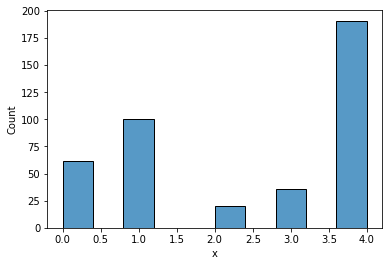

In [580]:
hist = pd.DataFrame(kmeans.labels_, columns= ['x'])
sns.histplot(data=hist, x='x')

In [581]:
MA = MA_grouped.shape[0]
DC = DC_grouped.shape[0]
SH = SH_grouped.shape[0]
BJ = BJ_grouped.shape[0]

In [582]:
MA_label = kmeans.labels_[0 : MA]
DC_label = kmeans.labels_[MA : MA+DC]
SH_label = kmeans.labels_[MA+DC : MA+DC+SH]
BJ_label = kmeans.labels_[MA+DC+SH : MA+DC+SH+BJ]